### Objectives
A fishing company will plan its fishing operation for the next day based on the forecasted weather condition. Specifically, the company will not send its fishermen out fishing during a storm to avoid higher maintenance costs. However, if they choose to stay in, due to incorrect forecast, while their competitors went out, they would lose out severely in terms of the size of their catch. Hence, the company has engaged you (an AI Engineer) to build models that make rain prediction for the next day. By the fishing company’s definition, it is said to have rained if there is more than 1.0 mm of rain in the day.

In your submission, you are to evaluate at least 3 suitable models for predicting whether it will rain the **next day**.

### Dataset
The dataset provided contains measurements that the company has collected at four different points in Singapore. Do note that there could be synthetic features in the dataset. Therefore you would need to state and verify any assumptions that you make.

### Libaries

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import missingno as msno
import seaborn as sns
from scipy import stats
from scipy.stats import kurtosis, skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [3]:
#Establishing connection with sqlite3
conn = sqlite3.connect('../data/fishing.db')

In [4]:
# Execute a SELECT statement
fishing_df = pd.read_sql_query("SELECT * FROM fishing", conn)

#A copy is made as it is indepedent of the dataframe, modifications made to copy will not affect main vice versa
fishing_df_copy = fishing_df.copy()

In [5]:
##Allow viewing of all columns 
pd.set_option('display.max_columns', None)

In [6]:
fishing_df_copy.head()

,Date,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,ColourOfBoats,AverageTemp
0,2009-03-08,Changi,0.0,7.0,11.2,E,35.0,E,ESE,15.0,19.0,60.0,54.0,MED,Med,4.0,5.0,No,No,blue,33.4
1,2014-11-12,Woodlands,0.0,8.4,9.6,WNW,37.0,NNE,NW,13.0,28.0,60.0,56.0,MeD,LOw,1.0,2.0,None,Yes,blue,35.4
2,2008-08-08,Woodlands,0.0,7.6,11.1,ESE,52.0,SE,E,19.0,19.0,NaN,13.0,Med,MEd,0.0,0.0,None,No,blue,32.8
3,2015-10-12,Changi,0.0,7.2,11.4,NE,31.0,NNW,NE,9.0,13.0,51.0,53.0,hIgh,med,1.0,1.0,No,No,red,31.4
4,2013-10-27,Woodlands,5.6,7.0,8.5,NNW,33.0,N,N,13.0,19.0,68.0,64.0,meD,MeD,6.0,5.0,None,No,grey,35.4


In [7]:
#Since we using datetime, it will be better to arrange it according to date
fishing_df_copy.sort_values('Date', inplace=True)
fishing_df_copy.head()

,Date,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,ColourOfBoats,AverageTemp
605,2008-07-01,Woodlands,0.0,4.4,11.0,E,41.0,ENE,SSE,13.0,17.0,81.0,32.0,Med,mEd,1.0,2.0,No,No,white,34.0
4425,2008-07-01,Sentosa,2.0,2.8,7.0,W,63.0,W,W,37.0,35.0,60.0,38.0,loW,mEd,1.0,7.0,None,No,blue,27.0
11774,2008-07-01,Tuas,0.0,0.8,9.1,ENE,20.0,None,E,0.0,7.0,97.0,53.0,hIGH,HiGH,2.0,3.0,None,No,grey,26.1
418,2008-07-01,Changi,0.0,1.4,9.5,WNW,26.0,SSW,W,6.0,15.0,81.0,37.0,mEd,Med,0.0,1.0,No,No,blue,29.6
4343,2008-07-02,Changi,0.0,2.0,9.8,W,30.0,W,WNW,15.0,19.0,41.0,30.0,MeD,mEd,0.0,0.0,None,No,red,28.5


In [8]:
#For datetime, we should split the date column into year, month and day and keeping date for time series analysis later one

In [9]:
DatelID = fishing_df_copy.columns.get_loc('Date')
fishing_df_copy['Date']= pd.to_datetime(fishing_df_copy['Date'],format='%Y-%m-%d')
fishing_df_copy['Year'] = fishing_df_copy['Date'].dt.year
fishing_df_copy['Month'] = fishing_df_copy['Date'].dt.month
fishing_df_copy['Day'] = fishing_df_copy['Date'].dt.day
fishing_df_copy.insert(DatelID + 1, "Year", fishing_df_copy.pop("Year"))
fishing_df_copy.insert(DatelID + 1, "Month", fishing_df_copy.pop("Month"))
fishing_df_copy.insert(DatelID + 1, "Day", fishing_df_copy.pop("Day"))

## Exploratory Data Analysis(EDA)

### Data Cleaning and Transformation

In [10]:
fishing_df_copy.shape
#This shows that there is 12997 rows and 21 columns

(12997, 24)

In [11]:
fishing_df_copy.isnull().sum()

Date                0
Day                 0
Month               0
Year                0
Location            0
Rainfall            0
Evaporation        80
Sunshine           58
WindGustDir        84
WindGustSpeed      80
WindDir9am        300
WindDir3pm         52
WindSpeed9am        5
WindSpeed3pm        6
Humidity9am        14
Humidity3pm        27
Pressure9am         2
Pressure3pm         8
Cloud9am          304
Cloud3pm          382
RainToday        3198
RainTomorrow        0
ColourOfBoats       0
AverageTemp         9
dtype: int64

In [12]:
# find columns with missing values
null_columns = fishing_df_copy.columns[fishing_df_copy.isnull().any()]

print(f"Total dataset: {len(fishing_df_copy)}")
# calculate length of missing values in each column
for col in null_columns:
    null_count = len(fishing_df_copy[fishing_df_copy[col].isnull()])
    total_count = len(fishing_df_copy)
    print(f"Column {col} has {null_count/len(fishing_df_copy)*100:.2f}% Missing")

Total dataset: 12997
Column Evaporation has 0.62% Missing
Column Sunshine has 0.45% Missing
Column WindGustDir has 0.65% Missing
Column WindGustSpeed has 0.62% Missing
Column WindDir9am has 2.31% Missing
Column WindDir3pm has 0.40% Missing
Column WindSpeed9am has 0.04% Missing
Column WindSpeed3pm has 0.05% Missing
Column Humidity9am has 0.11% Missing
Column Humidity3pm has 0.21% Missing
Column Pressure9am has 0.02% Missing
Column Pressure3pm has 0.06% Missing
Column Cloud9am has 2.34% Missing
Column Cloud3pm has 2.94% Missing
Column RainToday has 24.61% Missing
Column AverageTemp has 0.07% Missing


#### For RainToday, there seems to be a large perecentage of missing data of the whole dataset (24.61%) it is unwise to remove all the data.
#### In this case, I will rename the None variable to provide a third category called "Unknown" as shown below
#### For all the other columns, I will remove the null values as they consists small perecentage of the whole dataset 

In [13]:
fishing_df_copy['RainToday'].fillna('Unknown', inplace=True)

In [14]:
fishing_df_copy.isnull().sum()
#As you can see column RainToday has no missing values

Date               0
Day                0
Month              0
Year               0
Location           0
Rainfall           0
Evaporation       80
Sunshine          58
WindGustDir       84
WindGustSpeed     80
WindDir9am       300
WindDir3pm        52
WindSpeed9am       5
WindSpeed3pm       6
Humidity9am       14
Humidity3pm       27
Pressure9am        2
Pressure3pm        8
Cloud9am         304
Cloud3pm         382
RainToday          0
RainTomorrow       0
ColourOfBoats      0
AverageTemp        9
dtype: int64

In [15]:
fishing_df_copy_no_missing = fishing_df_copy.dropna()

#### PENDING: Lets further explore on the missing data using the missingno library
https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009
https://towardsdatascience.com/4-techniques-to-handle-missing-values-in-time-series-data-c3568589b5a8

In [16]:
#msno.bar(fishing_df_copy)
#On first glance in the Missingno barplot, all the columns do not have a large persentage
#of missing data apart form "RainToday" column

#### As we are dealing with time data, MissingNo matrix is useful to determine which part is missing

In [17]:
#msno.matrix(fishing_df_copy)

#### As we are dealing with time data, MissingNo dendrogram is useful to determine which part is missing
If a number of columns are grouped together at level zero, then the presence of nulls in one of those columns is directly related to the presence or absence of nulls in the others columns. The more separated the columns in the tree, the less likely the null values can be correlated between the columns.

In [18]:
#msno.dendrogram(fishing_df_copy)

In [19]:
#Lets see the shape of the df with no missing values
fishing_df_copy_no_missing.shape
#Current dataframe consists of 12026 rows and 24 columns 

(12026, 24)

In [20]:
fishing_df_copy_no_missing.shape[0]/len(fishing_df_copy)
#As seen below roughly 8% data is eliminated, which is quite a small percentage

0.9252904516426868

### EDA Numerical Variables

In [21]:
#Lets take a look at the summary desriptive statistics of the numerical variables without date variables
fishing_df_copy_no_missing_noDate = fishing_df_copy_no_missing.drop(columns=['Date', 'Day', 'Month', 'Year'], inplace = False)
fishing_df_copy_no_missing_noDate.describe()

,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,AverageTemp
count,12026.000000,12026.000000,12026.000000,12026.000000,12026.000000,12026.000000,12026.000000,12026.000000,12026.000000,12026.000000,12026.000000
mean,2.705056,5.601472,6.568452,36.527108,12.518959,16.668468,65.038334,50.588724,4.068019,4.090138,31.592574
std,8.812184,2.864470,6.040543,12.323220,7.896293,7.680854,15.267683,16.763816,2.720315,2.643476,2.943306
min,0.000000,0.000000,-13.500000,11.000000,2.000000,2.000000,11.000000,5.000000,0.000000,0.000000,24.300000
25%,0.000000,3.400000,4.200000,28.000000,7.000000,11.000000,55.000000,40.000000,1.000000,1.000000,29.125000
50%,0.000000,5.600000,8.800000,35.000000,11.000000,15.000000,66.000000,51.000000,4.000000,4.000000,31.900000
75%,0.800000,7.400000,10.700000,43.000000,17.000000,20.000000,76.000000,61.000000,7.000000,7.000000,34.200000
max,182.600000,44.000000,13.900000,104.000000,65.000000,76.000000,100.000000,99.000000,8.000000,8.000000,38.500000


From the statistics there seems to be a this error
1. The column Sunshine as the minimum is -13.5 hours which is not possible for a scalar value
We will have to take a look for the column "Sunshine" for further investigations
2. The column Evaporation as the minimum is 0 which is technically possible but very unlikely as water evaporates in any given day
More investigations are conducted in the new few cells

In [22]:
fishing_df_copy_no_missing.query("Sunshine < 0")

,Date,Day,Month,Year,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,ColourOfBoats,AverageTemp
4011,2008-07-11,11,7,2008,Woodlands,0.0,8.0,-10.9,E,41.0,ESE,NE,20.0,11.0,21.0,11.0,MeD,mEd,1.0,0.0,No,No,blue,32.8
12542,2008-07-12,12,7,2008,Changi,0.0,2.2,-8.1,ENE,30.0,SW,E,7.0,15.0,60.0,48.0,HIGh,higH,1.0,6.0,No,No,blue,28.0
9210,2008-07-13,13,7,2008,Sentosa,0.0,3.8,-4.2,N,87.0,N,N,33.0,44.0,49.0,55.0,mEd,MED,7.0,4.0,Unknown,No,blue,26.4
4190,2008-07-22,22,7,2008,Sentosa,2.4,1.6,-4.4,SSW,41.0,WSW,SSW,15.0,13.0,78.0,62.0,hIGh,hIgH,6.0,6.0,Yes,No,blue,25.5
5955,2008-07-26,26,7,2008,Sentosa,0.0,2.0,-4.0,N,41.0,N,NNE,24.0,20.0,79.0,54.0,med,mEd,4.0,7.0,No,Yes,red,25.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,2017-06-20,20,6,2017,Tuas,0.0,2.8,-9.1,NW,26.0,W,NNW,7.0,11.0,98.0,59.0,med,MEd,1.0,1.0,No,No,red,28.3
10707,2017-06-22,22,6,2017,Woodlands,0.0,5.6,-11.0,E,33.0,E,W,17.0,11.0,46.0,23.0,Med,meD,0.0,0.0,No,No,red,34.1
3355,2017-06-23,23,6,2017,Changi,0.0,3.2,-9.4,W,24.0,SW,W,6.0,9.0,71.0,37.0,hIgH,Med,1.0,3.0,No,No,white,29.3
10273,2017-06-23,23,6,2017,Changi,0.0,3.2,-9.4,W,24.0,SW,W,6.0,9.0,71.0,37.0,hIgH,Med,1.0,3.0,No,No,white,29.3


Further analysis shows that there is 1148 rows that are negative. My assumption is that there is human error
Hence, I will change the data by making it the positive value of what is should be

In [23]:
fishing_df_copy_no_missing["Sunshine"] = fishing_df_copy_no_missing["Sunshine"].apply(lambda x: x *(-1) if x < 0 else x )

/var/folders/j0/zzt4z9p97ns3p77mp_qltfq40000gn/T/ipykernel_21420/4262162143.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fishing_df_copy_no_missing["Sunshine"] = fishing_df_copy_no_missing["Sunshine"].apply(lambda x: x *(-1) if x < 0 else x )


In [24]:
invalid_evaporation = len(fishing_df_copy_no_missing.query('Evaporation ==  0'))
print(f'Percentage total of data with invalid evaporation: {invalid_evaporation/len(fishing_df_copy_no_missing)*100:.2f}%')
fishing_df_copy_no_missing.query("Evaporation ==  0")

Percentage total of data with invalid evaporation: 0.17%


,Date,Day,Month,Year,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,ColourOfBoats,AverageTemp
12135,2010-09-21,21,9,2010,Changi,22.4,0.0,0.4,W,19.0,SSW,W,6.0,7.0,93.0,78.0,mED,MeD,7.0,7.0,Yes,No,blue,30.6
6975,2011-07-12,12,7,2011,Tuas,4.8,0.0,9.3,NE,30.0,ENE,ENE,9.0,11.0,76.0,62.0,MED,mEd,5.0,3.0,Yes,No,white,27.5
12834,2011-07-20,20,7,2011,Sentosa,0.2,0.0,0.0,SSE,54.0,SE,SSE,30.0,30.0,75.0,66.0,higH,higH,7.0,7.0,No,No,white,26.6
12975,2011-08-10,10,8,2011,Sentosa,1.2,0.0,0.0,S,48.0,N,S,9.0,15.0,82.0,87.0,lOW,mED,7.0,8.0,Yes,Yes,grey,25.9
8694,2011-08-11,11,8,2011,Sentosa,3.4,0.0,1.9,SSE,43.0,SSE,S,26.0,19.0,73.0,57.0,med,MED,6.0,7.0,Yes,No,red,27.2
721,2012-06-01,1,6,2012,Changi,6.0,0.0,3.2,ESE,26.0,SSE,E,6.0,11.0,88.0,85.0,higH,HIgh,7.0,7.0,Yes,Yes,grey,29.7
11975,2012-06-04,4,6,2012,Sentosa,7.0,0.0,0.0,SSE,70.0,S,SE,15.0,22.0,92.0,89.0,low,LoW,7.0,8.0,Unknown,Yes,grey,26.7
12054,2012-06-05,5,6,2012,Sentosa,11.2,0.0,0.5,SSE,70.0,SSE,SSE,44.0,35.0,57.0,65.0,MED,Med,7.0,7.0,Yes,No,grey,26.6
11796,2012-07-12,12,7,2012,Tuas,0.0,0.0,7.8,SSW,30.0,SSE,S,7.0,17.0,78.0,58.0,HIGh,higH,0.0,3.0,No,No,blue,25.6
8586,2012-07-12,12,7,2012,Tuas,0.0,0.0,7.8,SSW,30.0,SSE,S,7.0,17.0,78.0,58.0,HIGh,higH,0.0,3.0,No,No,blue,25.6


As seen above, there are about 0.17% invalid data for the column evaporation. It will be safe to remove

In [25]:
fishing_df_copy_no_missing =  fishing_df_copy_no_missing.query('Evaporation >  0')

In [26]:
print(fishing_df_copy_no_missing.shape) #Total shape is 12006 by 24
fishing_df_copy_no_missing_noDate = fishing_df_copy_no_missing.drop(columns=['Date', 'Day', 'Month', 'Year'], inplace = False)
fishing_df_copy_no_missing_noDate.describe()
#There seems to be not much issues with the dataset(excluding Date) for now

(12006, 24)


,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,AverageTemp
count,12006.000000,12006.000000,12006.000000,12006.000000,12006.000000,12006.000000,12006.000000,12006.000000,12006.000000,12006.000000,12006.000000
mean,2.702549,5.610803,8.182850,36.528486,12.520990,16.668582,65.010411,50.562469,4.065634,4.087956,31.598434
std,8.816147,2.857709,3.571067,12.318073,7.891952,7.680166,15.259455,16.758844,2.720099,2.644021,2.940324
min,0.000000,0.200000,0.000000,11.000000,2.000000,2.000000,11.000000,5.000000,0.000000,0.000000,24.300000
25%,0.000000,3.400000,5.900000,28.000000,7.000000,11.000000,55.000000,40.000000,1.000000,1.000000,29.200000
50%,0.000000,5.600000,9.300000,35.000000,11.000000,15.000000,66.000000,51.000000,4.000000,4.000000,31.900000
75%,0.600000,7.400000,10.900000,43.000000,17.000000,20.000000,76.000000,61.000000,7.000000,7.000000,34.200000
max,182.600000,44.000000,13.900000,104.000000,65.000000,76.000000,100.000000,99.000000,8.000000,8.000000,38.500000


## Univariate Analysis of Numerical Exploratory Variables

In [27]:
numerical_cols = ["Rainfall", "Evaporation", "Sunshine", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm", "Cloud9am", "Cloud3pm", "AverageTemp"]

### Univariate non-graphical EDA

#### Measuring Kurtosis and Skewness

In [28]:
def skewness_kurtosis_dataframe(dataframe, numerical_cols):
    skewness_kurtosis_data =  []
    index = []
    for cols in dataframe[numerical_cols].columns:
        current_skewness_kurtosis = []
        print(cols)
        current_skewness_kurtosis.append(skew(dataframe[cols], bias=False))
        current_skewness_kurtosis.append(kurtosis(dataframe[cols], bias=False))
        skewness_kurtosis_data.append(current_skewness_kurtosis)
        index.append(cols)
    skewness_kurtosis_df = pd.DataFrame(skewness_kurtosis_data, columns = ['Skewness', 'Kurtosis'])
    skewness_kurtosis_df.index = index

    skewness_categories = []
    for val in skewness_kurtosis_df['Skewness']:
        if val < -1:
            skewness_categories.append("Highly skewed")
        elif val >= -1 and val < -0.5:
            skewness_categories.append("Moderately skewed (left)")
        elif val >= -0.5 and val <= 0.5:
            skewness_categories.append("Fairly symmetrical")
        elif val > 0.5 and val <= 1:
            skewness_categories.append("Moderately skewed (right)")
        else:
            skewness_categories.append("Highly skewed")

    # Categorize Kurtosis
    kurtosis_categories = []
    for val in skewness_kurtosis_df['Kurtosis']:
        if val > 3:
            kurtosis_categories.append("Heavier tails")
        elif val < 3:
            kurtosis_categories.append("Lighter tails")
        else:
            kurtosis_categories.append("Mesokurtic")

    skewness_kurtosis_df['Skewness Category'] = skewness_categories
    skewness_kurtosis_df['Kurtosis Category'] = kurtosis_categories
    skewness_kurtosis_df[['Skewness', 'Kurtosis', 'Skewness Category', 'Kurtosis Category']]

    return skewness_kurtosis_df

In [29]:
skewness_kurtosis_dataframe(fishing_df_copy_no_missing, numerical_cols)

Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Cloud9am
Cloud3pm
AverageTemp


,Skewness,Kurtosis,Skewness Category,Kurtosis Category
Rainfall,7.014693,75.207368,Highly skewed,Heavier tails
Evaporation,0.686864,2.934185,Moderately skewed (right),Lighter tails
Sunshine,-0.800006,-0.364605,Moderately skewed (left),Lighter tails
WindGustSpeed,1.163243,2.520418,Highly skewed,Lighter tails
WindSpeed9am,1.646251,4.223722,Highly skewed,Heavier tails
WindSpeed3pm,0.865739,1.542228,Moderately skewed (right),Lighter tails
Humidity9am,-0.310723,0.061414,Fairly symmetrical,Lighter tails
Humidity3pm,0.099318,0.038013,Fairly symmetrical,Lighter tails
Cloud9am,-0.092424,-1.564491,Fairly symmetrical,Lighter tails
Cloud3pm,-0.070996,-1.529607,Fairly symmetrical,Lighter tails


Skewness refers to distortion or asymmetry in a symmetrical bell curve, or normal distribution, in a set of data
Kurtosis is the defined as the the sharpness of the peak of a frequency-distribution curve
- If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
- If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed
- If the skewness is less than -1 or greater than 1, the data are highly skewed
- If the kurtosis is greater than 3, then the dataset has heavier tails than a normal distribution (more in the tails)
- If the kurtosis is less than 3, then the dataset has lighter tails than a normal distribution (less in the tails)

From the dataframe above,

**Skewness**
- Rainfall, WindGustSpeed, WindSpeed9am is Highly Skewed
- Evaporation, Sunshine is Moderately Skewed

**Kurtosis**
- "Rainfall", "WindSpeed9am" has Heavy Tails
- "Evaporation", "Sunshine", "WindGustSpeed", "WindSpeed3pm", "Humidity9am", "Humidity3pm", "Cloud9am", "Cloud3pm", "AverageTemp" has Lighter Tails

### Univariate Boxplots
### Rainfall, Evaporation, Sunshine, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm, Cloud9am, Cloud3pm, AverageTemp

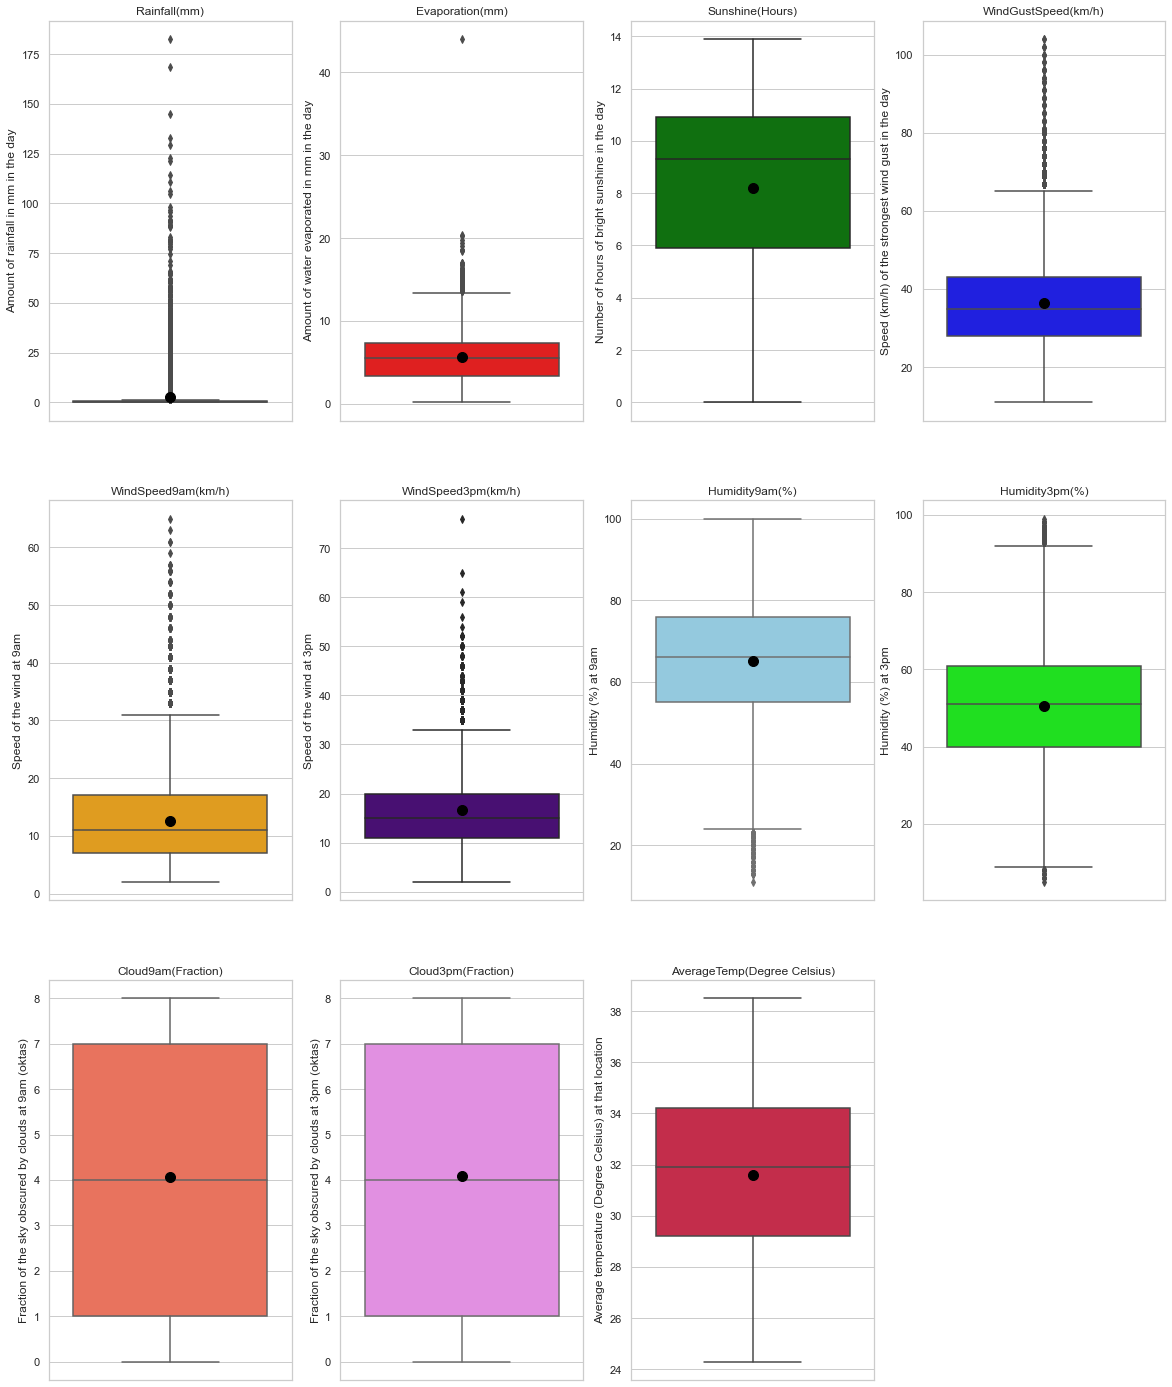

In [30]:
plt.figure(figsize=(20,25))
sns.set(style="whitegrid")

plt.subplot(3,4,1)
plt.title("Rainfall(mm)")
ax = sns.boxplot(y="Rainfall",data=fishing_df_copy_no_missing,         
            color = "blue", 
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"} )

plt.ylabel("Amount of rainfall in mm in the day")

plt.subplot(3,4,2)
plt.title("Evaporation(mm)")
sns.boxplot(y="Evaporation",data=fishing_df_copy_no_missing,
            color = "red",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Amount of water evaporated in mm in the day")

plt.subplot(3,4,3)
plt.title("Sunshine(Hours)")
sns.boxplot(y="Sunshine",data=fishing_df_copy_no_missing,
            color = "green",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Number of hours of bright sunshine in the day")

plt.subplot(3,4,4)
plt.title("WindGustSpeed(km/h)")
sns.boxplot(y="WindGustSpeed",data=fishing_df_copy_no_missing,
            color = "blue",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Speed (km/h) of the strongest wind gust in the day")

plt.subplot(3,4,5)
plt.title("WindSpeed9am(km/h)")
sns.boxplot(y="WindSpeed9am",data=fishing_df_copy_no_missing,
            color = "orange",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Speed of the wind at 9am")

plt.subplot(3,4,6)
plt.title("WindSpeed3pm(km/h)")
sns.boxplot(y="WindSpeed3pm",data=fishing_df_copy_no_missing,
            color = "indigo",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Speed of the wind at 3pm")

plt.subplot(3,4,7)
plt.title("%")
plt.title("Humidity9am(%)")
sns.boxplot(y="Humidity9am",data=fishing_df_copy_no_missing,
            color = "skyblue",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Humidity (%) at 9am")

plt.subplot(3,4,8)
plt.title("%")
plt.title("Humidity3pm(%)")
sns.boxplot(y="Humidity3pm",data=fishing_df_copy_no_missing,
            color = "lime",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Humidity (%) at 3pm")

plt.subplot(3,4,9)
plt.title("Cloud9am(Fraction)")
sns.boxplot(y="Cloud9am",data=fishing_df_copy_no_missing,
            color = "tomato",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Fraction of the sky obscured by clouds at 9am (oktas)")

plt.subplot(3,4,10)
plt.title("Cloud3pm(Fraction)")
sns.boxplot(y="Cloud3pm",data=fishing_df_copy_no_missing,
            color = "violet",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Fraction of the sky obscured by clouds at 3pm (oktas)")


plt.subplot(3,4,11)
plt.title("AverageTemp(Degree Celsius)")
sns.boxplot(y="AverageTemp",data=fishing_df_copy_no_missing,
            color = "crimson",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Average temperature (Degree Celsius) at that location")


plt.show()

From the boxplot graphs of all the numerical variables, there are seem to have outliers for the columns
Rainfall, Evaporation, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm

Checking for outliers 
Outliers are defined as more than 3/2 of upper quartile or 3/2 of the lower quartile

In [31]:
# Create a new dataframe with only the selected columns
data = fishing_df_copy_no_missing[numerical_cols]

# Calculate the number of outliers in each column using the boxplot method
outliers = data.apply(lambda x: pd.Series(x).quantile(0.75) + 1.5 * (pd.Series(x).quantile(0.75) - pd.Series(x).quantile(0.25)) < pd.Series(x))

# Print the number of outliers in each column
print(outliers.sum())

Rainfall         2565
Evaporation        97
Sunshine            0
WindGustSpeed     352
WindSpeed9am      290
WindSpeed3pm      293
Humidity9am         0
Humidity3pm       108
Cloud9am            0
Cloud3pm            0
AverageTemp         0
dtype: int64


### Univariate Histograms
### Rainfall, Evaporation, Sunshine, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm, Cloud9am, Cloud3pm, AverageTemp
### Using Struge' rule, the number of bins = 1 + ceil(log2(n))

In [32]:
bin_count = int(np.ceil(np.log2(len(fishing_df_copy_no_missing))) + 1)

Text(0.5, 0, 'AverageTemp/Average temperature (Degree Celsius) at that location')

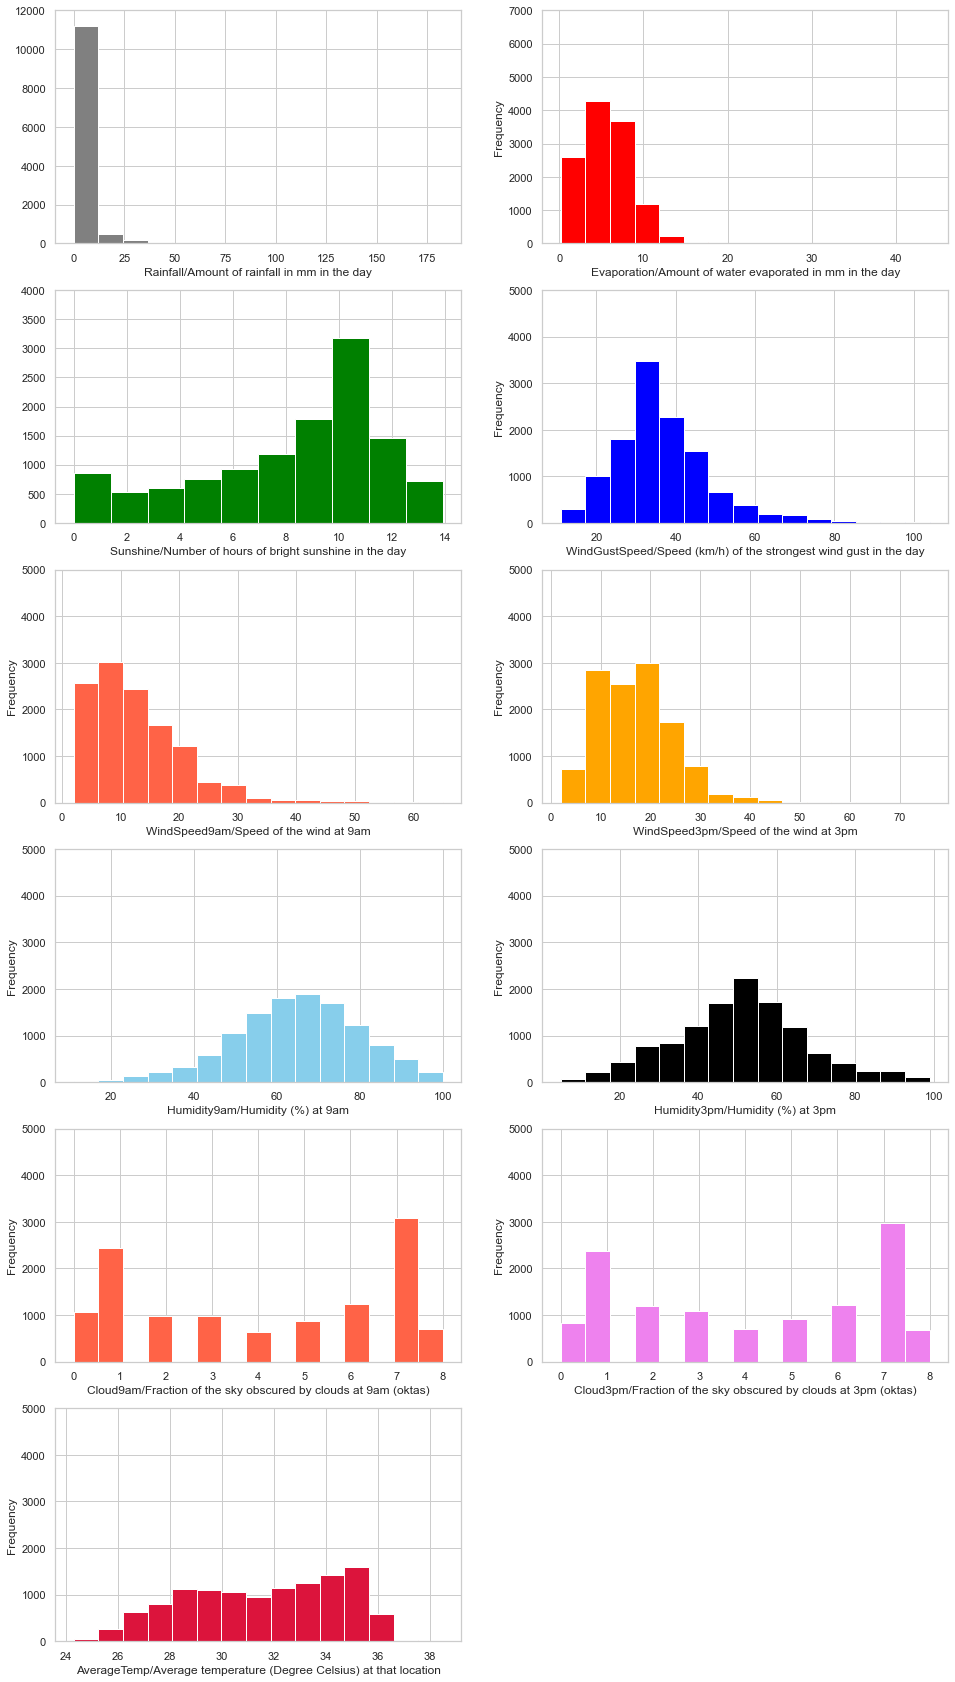

In [33]:
plt.figure(figsize=(16,30))
sns.set(style="whitegrid")
plt.subplot(6,2,1)
plt.ylim(0, 12000)
fishing_df_copy_no_missing["Rainfall"].hist(color ="gray" , bins = 15)
plt.xlabel("Rainfall/Amount of rainfall in mm in the day")

plt.subplot(6,2,2)
plt.ylim(0, 7000)
fishing_df_copy_no_missing["Evaporation"].plot.hist(color ="red", bins = 15)
#fishing_df_copy_no_missing["Evaporation"].plot.hist(color ="orange", bins = 15)
plt.xlabel("Evaporation/Amount of water evaporated in mm in the day")

plt.subplot(6,2,3)
plt.ylim(0, 4000)
fishing_df_copy_no_missing["Sunshine"].hist(color ="green", bins = 10)
plt.xlabel("Sunshine/Number of hours of bright sunshine in the day")

sns.set(style="whitegrid")
plt.subplot(6,2,4)
plt.ylim(0, 5000)
fishing_df_copy_no_missing["WindGustSpeed"].plot.hist(color ="blue", bins = 15)
plt.xlabel("WindGustSpeed/Speed (km/h) of the strongest wind gust in the day")

plt.subplot(6,2,5)
plt.ylim(0, 5000)
fishing_df_copy_no_missing["WindSpeed9am"].plot.hist(color ="tomato", bins = 15)
#fishing_df_copy_no_missing["WindSpeed9am"].plot.hist(color ="orange", bins = 15)
plt.xlabel("WindSpeed9am/Speed of the wind at 9am")

plt.subplot(6,2,6) 
plt.ylim(0, 5000)
fishing_df_copy_no_missing["WindSpeed3pm"].plot.hist(color ="orange", bins = 15)
#fishing_df_copy_no_missing["WindSpeed3pm"].plot.hist(color ="orange", bins = 15)
plt.xlabel("WindSpeed3pm/Speed of the wind at 3pm")

plt.subplot(6,2,7)
plt.ylim(0, 5000)
fishing_df_copy_no_missing["Humidity9am"].plot.hist(color ="skyblue", bins = 15)
plt.xlabel("Humidity9am/Humidity (%) at 9am")

plt.subplot(6,2,8)
plt.ylim(0, 5000)
fishing_df_copy_no_missing["Humidity3pm"].plot.hist(color ="black", bins = 15)
plt.xlabel("Humidity3pm/Humidity (%) at 3pm")

plt.subplot(6,2,9)
plt.ylim(0, 5000)
fishing_df_copy_no_missing["Cloud9am"].plot.hist(color ="tomato", bins = 15)
plt.xlabel("Cloud9am/Fraction of the sky obscured by clouds at 9am (oktas)")

plt.subplot(6,2,10)
plt.ylim(0, 5000)
fishing_df_copy_no_missing["Cloud3pm"].plot.hist(color ="violet", bins = 15)
plt.xlabel("Cloud3pm/Fraction of the sky obscured by clouds at 3pm (oktas)")
plt.subplot(6,2,11)
plt.ylim(0, 5000)
fishing_df_copy_no_missing["AverageTemp"].plot.hist(color ="crimson", bins = 15)
plt.xlabel("AverageTemp/Average temperature (Degree Celsius) at that location")

In [34]:
print(len(fishing_df_copy_no_missing.query("Rainfall == 0"))/len(fishing_df_copy_no_missing))

0.6700816258537398


From the histogram, boxtplot and outliers calculations these are my observations
1) Column "Rainfall" is extremely skewed as it has about 2565 values that is outside of the interquartile range. From the above calculations, there is about 67% of data that contains 0, meaning the column is highly sparse. SMOTE(Synthetic Minority Oversampling Technique) could be used but we have to change the categorical variables into OHC. I will have to take a look at the class porportion of responding variable RainTomorrow first as it may have the same issues
2) The column WindGustSpeed, WindSpeed9am is also highly skewed as there is quite a lot of values on the RHS and LHS visually
3) The column Evaporation, WindSpeed3pm seems to slightly skewed on the right while Sunshine seems to be slightly skewed to the left
- For pointer 2) and 3), we could use some logarithm transformation to correct this skewness
3) Cloud9am, Cloud3pm seems to be slighly disjointed but that is normal as they seem to be whole numbers. Perhaps we could use OHC for this two columns

### Data Transformation

Based on the Skewness, Kurtosis, Boxplot and Histogram, the columns WindGustSpeed, WindSpeed9am, Evaporation, WindSpeed3pm,Sunshine can be transformed using the log(1+x) transformation.
Log(1+x) is used as logramithm does not work with 0 numbers

In [35]:
fishing_df_copy_no_missing

,Date,Day,Month,Year,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,ColourOfBoats,AverageTemp
605,2008-07-01,1,7,2008,Woodlands,0.0,4.4,11.0,E,41.0,ENE,SSE,13.0,17.0,81.0,32.0,Med,mEd,1.0,2.0,No,No,white,34.0
4425,2008-07-01,1,7,2008,Sentosa,2.0,2.8,7.0,W,63.0,W,W,37.0,35.0,60.0,38.0,loW,mEd,1.0,7.0,Unknown,No,blue,27.0
418,2008-07-01,1,7,2008,Changi,0.0,1.4,9.5,WNW,26.0,SSW,W,6.0,15.0,81.0,37.0,mEd,Med,0.0,1.0,No,No,blue,29.6
4343,2008-07-02,2,7,2008,Changi,0.0,2.0,9.8,W,30.0,W,WNW,15.0,19.0,41.0,30.0,MeD,mEd,0.0,0.0,Unknown,No,red,28.5
7584,2008-07-02,2,7,2008,Tuas,0.0,1.8,7.0,NE,22.0,ESE,ENE,6.0,9.0,80.0,39.0,higH,HIGh,0.0,6.0,No,No,white,27.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12534,2017-06-24,24,6,2017,Sentosa,1.4,1.8,5.6,SW,30.0,WNW,S,11.0,2.0,75.0,63.0,MEd,mEd,2.0,7.0,Yes,No,blue,25.9
12254,2017-06-24,24,6,2017,Tuas,0.0,3.8,9.3,SE,30.0,ESE,ESE,9.0,11.0,62.0,47.0,hIgH,HIGH,1.0,3.0,No,No,blue,28.2
10368,2017-06-25,25,6,2017,Tuas,0.0,1.6,7.9,E,26.0,SE,SE,4.0,11.0,75.0,49.0,hIGh,HIGh,1.0,3.0,No,No,red,26.6
12243,2017-06-25,25,6,2017,Changi,0.0,2.2,9.8,ENE,20.0,SSW,NNE,2.0,7.0,68.0,53.0,Med,med,6.0,3.0,No,No,red,29.6


In [36]:
fishing_df_copy_no_missing_transformed = fishing_df_copy_no_missing[['WindGustSpeed', 'WindSpeed9am', 'Evaporation', 'WindSpeed3pm','Sunshine']].apply(lambda x: np.log1p(x+1))

In [37]:
fishing_df_copy_no_missing_transformed

,WindGustSpeed,WindSpeed9am,Evaporation,WindSpeed3pm,Sunshine
605,3.761200,2.708050,1.856298,2.944439,2.564949
4425,4.174387,3.663562,1.568616,3.610918,2.197225
418,3.332205,2.079442,1.223775,2.833213,2.442347
4343,3.465736,2.833213,1.386294,3.044522,2.468100
7584,3.178054,2.079442,1.335001,2.397895,2.197225
...,...,...,...,...,...
12534,3.465736,2.564949,1.335001,1.386294,2.028148
12254,3.465736,2.397895,1.757858,2.564949,2.424803
10368,3.332205,1.791759,1.280934,2.564949,2.292535
12243,3.091042,1.386294,1.435085,2.197225,2.468100


In [38]:
transformed_cols = ['WindGustSpeed', 'WindSpeed9am', 'Evaporation', 'WindSpeed3pm','Sunshine']
skewness_kurtosis_dataframe(fishing_df_copy_no_missing_transformed, transformed_cols)

WindGustSpeed
WindSpeed9am
Evaporation
WindSpeed3pm
Sunshine


,Skewness,Kurtosis,Skewness Category,Kurtosis Category
WindGustSpeed,0.031821,0.269117,Fairly symmetrical,Lighter tails
WindSpeed9am,0.042265,-0.126286,Fairly symmetrical,Lighter tails
Evaporation,-0.444750,-0.218294,Fairly symmetrical,Lighter tails
WindSpeed3pm,-0.463042,0.384852,Fairly symmetrical,Lighter tails
Sunshine,-1.618723,1.892963,Highly skewed,Lighter tails


From the above, 
The columns WindGustSpeed, WindSpeed9am, Evaporation, WindSpeed3pm seemed to be less skewed.

Let's confirm it with the Boxplots and Histogram

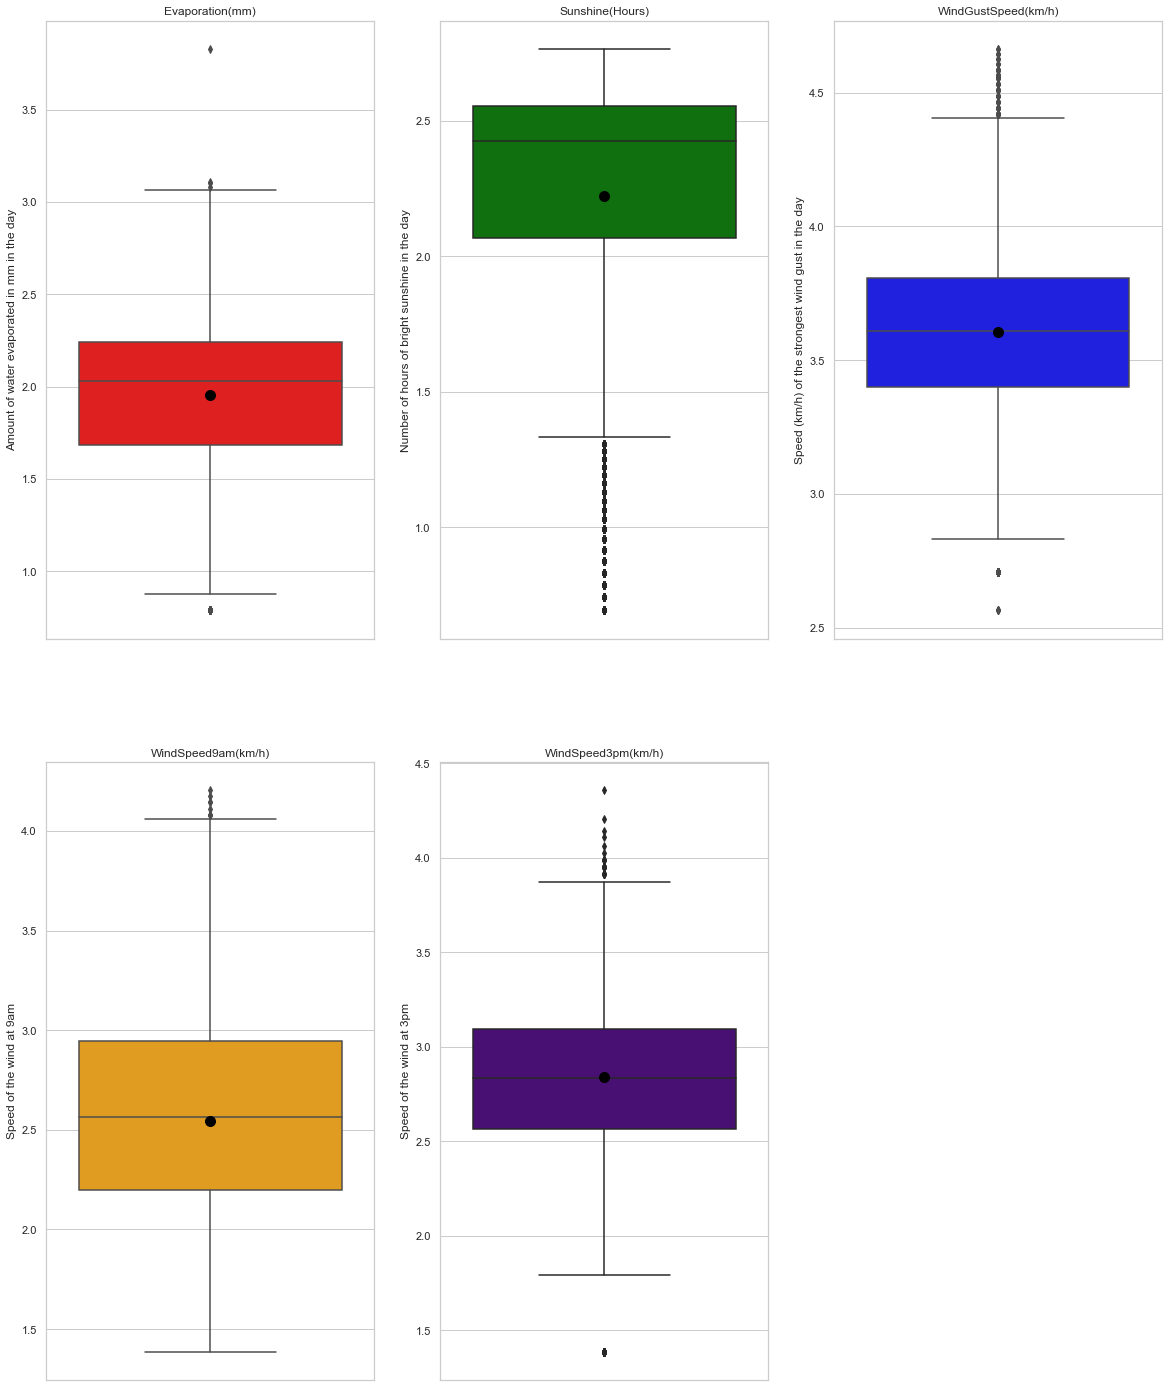

In [39]:
plt.figure(figsize=(20,25))
sns.set(style="whitegrid")


plt.subplot(2,3,1)
plt.title("Evaporation(mm)")
sns.boxplot(y="Evaporation",data=fishing_df_copy_no_missing_transformed,
            color = "red",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Amount of water evaporated in mm in the day")

plt.subplot(2,3,2)
plt.title("Sunshine(Hours)")
sns.boxplot(y="Sunshine",data=fishing_df_copy_no_missing_transformed,
            color = "green",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Number of hours of bright sunshine in the day")

plt.subplot(2,3,3)
plt.title("WindGustSpeed(km/h)")
sns.boxplot(y="WindGustSpeed",data=fishing_df_copy_no_missing_transformed,
            color = "blue",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Speed (km/h) of the strongest wind gust in the day")

plt.subplot(2,3,4)
plt.title("WindSpeed9am(km/h)")
sns.boxplot(y="WindSpeed9am",data=fishing_df_copy_no_missing_transformed,
            color = "orange",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Speed of the wind at 9am")

plt.subplot(2,3,5)
plt.title("WindSpeed3pm(km/h)")
sns.boxplot(y="WindSpeed3pm",data=fishing_df_copy_no_missing_transformed,
            color = "indigo",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Speed of the wind at 3pm")

plt.show()

Text(0.5, 0, 'WindSpeed3pm/Speed of the wind at 3pm')

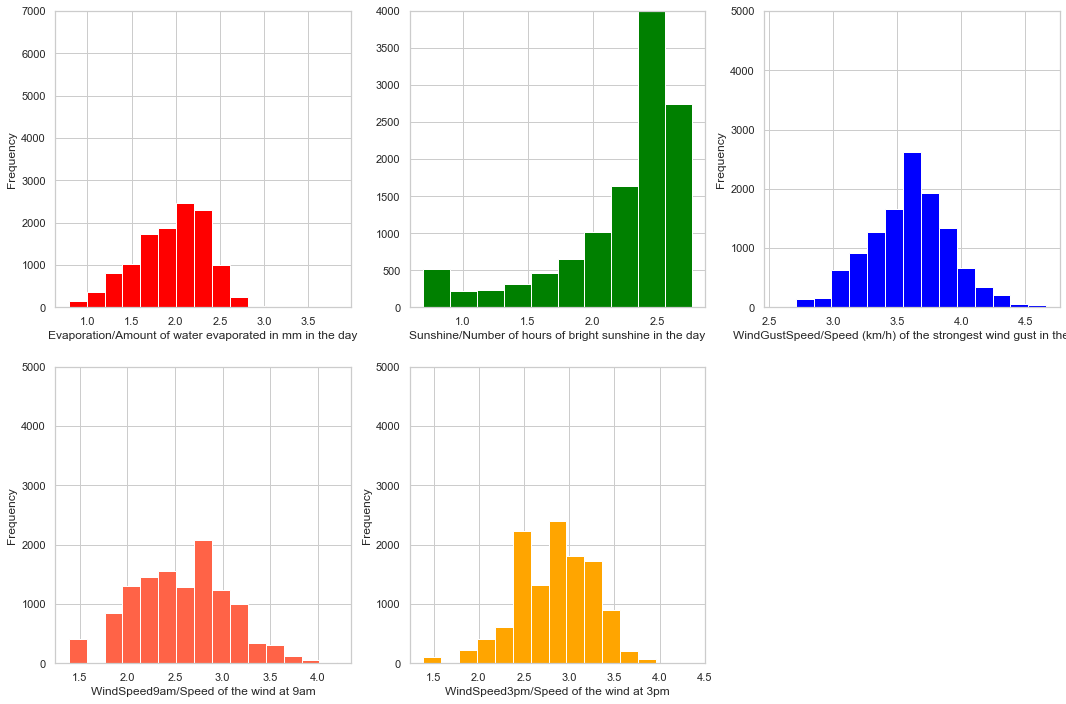

In [40]:
plt.figure(figsize=(18,12))
sns.set(style="whitegrid")

plt.subplot(2,3,1)
plt.ylim(0, 7000)
fishing_df_copy_no_missing_transformed["Evaporation"].plot.hist(color ="red", bins = 15)
#fishing_df_copy_no_missing["Evaporation"].plot.hist(color ="orange", bins = 15)
plt.xlabel("Evaporation/Amount of water evaporated in mm in the day")

plt.subplot(2,3,2)
plt.ylim(0, 4000)
fishing_df_copy_no_missing_transformed["Sunshine"].hist(color ="green", bins = 10)
plt.xlabel("Sunshine/Number of hours of bright sunshine in the day")

sns.set(style="whitegrid")
plt.subplot(2,3,3)
plt.ylim(0, 5000)
fishing_df_copy_no_missing_transformed["WindGustSpeed"].plot.hist(color ="blue", bins = 15)
plt.xlabel("WindGustSpeed/Speed (km/h) of the strongest wind gust in the day")

plt.subplot(2,3,4)
plt.ylim(0, 5000)
fishing_df_copy_no_missing_transformed["WindSpeed9am"].plot.hist(color ="tomato", bins = 15)
#fishing_df_copy_no_missing["WindSpeed9am"].plot.hist(color ="orange", bins = 15)
plt.xlabel("WindSpeed9am/Speed of the wind at 9am")

plt.subplot(2,3,5)
plt.ylim(0, 5000)
fishing_df_copy_no_missing_transformed["WindSpeed3pm"].plot.hist(color ="orange", bins = 15)
#fishing_df_copy_no_missing["WindSpeed3pm"].plot.hist(color ="orange", bins = 15)
plt.xlabel("WindSpeed3pm/Speed of the wind at 3pm")

From the histogram, the columns WindGustSpeed, WindSpeed9am, Evaporation, WindSpeed3pm seemed to be less skewed.
However, the column Sunshine had became more skewed values (as shown in the Skewness value after doing log(1+x) transformation) as compared to Moderately Skewed(left)

To reduce skewness lets try some more transformation function for the column "Sunshine"

In [41]:
fishing_df_copy_no_missing_sunshine_transformed = fishing_df_copy_no_missing[['Sunshine']].apply(lambda x: np.sqrt(x))

In [42]:
skewness_kurtosis_dataframe(fishing_df_copy_no_missing_sunshine_transformed, ['Sunshine'])

Sunshine


,Skewness,Kurtosis,Skewness Category,Kurtosis Category
Sunshine,-1.593868,2.087785,Highly skewed,Lighter tails


Text(0.5, 0, 'Sunshine/Number of hours of bright sunshine in the day')

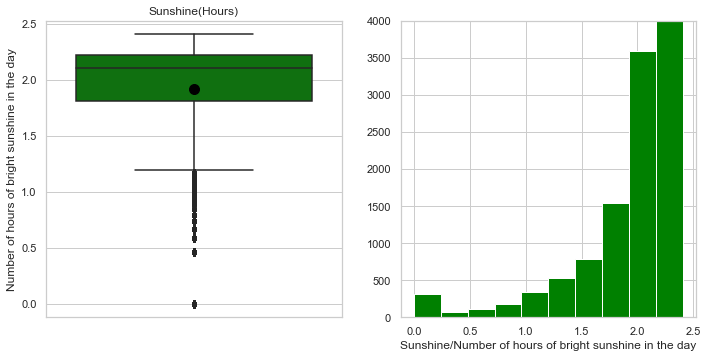

In [155]:
plt.figure(figsize=(18,12))
sns.set(style="whitegrid")
plt.subplot(2,3,1)
plt.title("Sunshine(Hours)")
sns.boxplot(y="Sunshine",data=fishing_df_copy_no_missing_sunshine_transformed,
            color = "green",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Number of hours of bright sunshine in the day")

plt.subplot(2,3,2)
plt.ylim(0, 4000)
fishing_df_copy_no_missing_sunshine_transformed["Sunshine"].hist(color ="green", bins = 10)
plt.xlabel("Sunshine/Number of hours of bright sunshine in the day")

From the skewness calculations, histogram and boxplot the columns "Sunshine" seemed to be highly skewed

To reduce skewness lets try cuberoot

In [44]:
fishing_df_copy_no_missing_sunshine_transformed = fishing_df_copy_no_missing[['Sunshine']].apply(lambda x: np.cbrt(x))

In [45]:
skewness_kurtosis_dataframe(fishing_df_copy_no_missing_sunshine_transformed, ['Sunshine'])

Sunshine


,Skewness,Kurtosis,Skewness Category,Kurtosis Category
Sunshine,-2.215437,5.169445,Highly skewed,Heavier tails


The values are still highly skewed after using this method
Let us try the MinMax scaling

In [46]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(fishing_df_copy_no_missing[['Sunshine']])
scaled_df = pd.DataFrame(scaled_data, columns=['Sunshine'])

skewness_kurtosis_dataframe(scaled_df, ['Sunshine'])

Sunshine


,Skewness,Kurtosis,Skewness Category,Kurtosis Category
Sunshine,-0.800006,-0.364605,Moderately skewed (left),Lighter tails


After using MinMax Scaling, there is still Modeerately Skewed(Left). This is similar the original untranformed dataset. Here are some options to go about

1. Remove column "Sunshine"
 - Removing it may improve performance in linear-regssion models but there might be 
 loss of information
2. Keep the column
- Tree-based models like XGBoost, RandomForest are more robust to Skewness so keeping might not affect the performance. Non-parameterised models are also another way to go about it

#### Combining the transformed and non-tranformed dataframe together

In [47]:
non_transformed_columns = fishing_df_copy_no_missing.drop(columns=transformed_cols)
fishing_df_copy_no_missing_tranformed_full = pd.concat([non_transformed_columns, fishing_df_copy_no_missing_transformed], axis=1)

### EDA: Exploratory Categorical Variables

In [48]:
categorical_cols = ['Location','WindDir9am', 'WindDir3pm','WindGustDir','Pressure9am', 'Pressure3pm', 'RainToday','ColourOfBoats']

In [50]:
fishing_df_copy_no_missing_transformed_categorical = fishing_df_copy_no_missing_tranformed_full[categorical_cols]
fishing_df_copy_no_missing_transformed_categorical

,Location,WindDir9am,WindDir3pm,WindGustDir,Pressure9am,Pressure3pm,RainToday,ColourOfBoats
605,Woodlands,ENE,SSE,E,Med,mEd,No,white
4425,Sentosa,W,W,W,loW,mEd,Unknown,blue
418,Changi,SSW,W,WNW,mEd,Med,No,blue
4343,Changi,W,WNW,W,MeD,mEd,Unknown,red
7584,Tuas,ESE,ENE,NE,higH,HIGh,No,white
...,...,...,...,...,...,...,...,...
12534,Sentosa,WNW,S,SW,MEd,mEd,Yes,blue
12254,Tuas,ESE,ESE,SE,hIgH,HIGH,No,blue
10368,Tuas,SE,SE,E,hIGh,HIGh,No,red
12243,Changi,SSW,NNE,ENE,Med,med,No,red


On one glance, the values in Pressure9am and Pressure3pm are "dirty". As such there is a need to lower case values to keep them constant

In [51]:
fishing_df_copy_no_missing_transformed_categorical["Pressure9am"] = fishing_df_copy_no_missing_transformed_categorical["Pressure9am"].apply(lambda x: x.lower())
fishing_df_copy_no_missing_transformed_categorical["Pressure3pm"] = fishing_df_copy_no_missing_transformed_categorical["Pressure3pm"].apply(lambda x: x.lower())

/var/folders/j0/zzt4z9p97ns3p77mp_qltfq40000gn/T/ipykernel_21420/3157016522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fishing_df_copy_no_missing_transformed_categorical["Pressure9am"] = fishing_df_copy_no_missing_transformed_categorical["Pressure9am"].apply(lambda x: x.lower())
/var/folders/j0/zzt4z9p97ns3p77mp_qltfq40000gn/T/ipykernel_21420/3157016522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fishing_df_copy_no_missing_transformed_categorical["Pressure3pm"] = fishing_df_copy_no_missing_

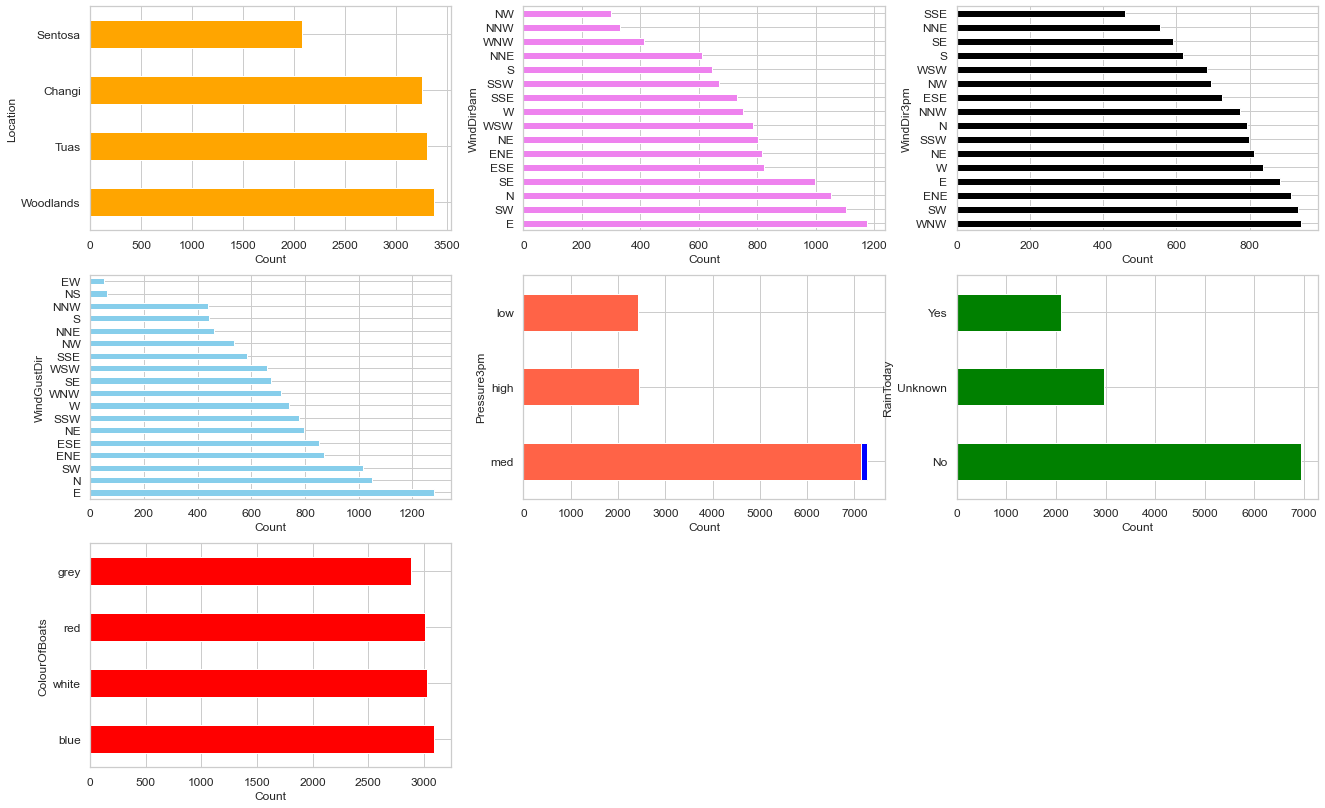

In [76]:
plt.figure(figsize=(22,14))
sns.set(style="whitegrid")

plt.subplot(3,3,1)
Location_category_count= fishing_df_copy_no_missing_transformed_categorical["Location"].value_counts().sort_index()
Location_category_count.sort_values(ascending = False, inplace = True)
Location_category_count.plot(kind = 'barh', fontsize=12, color="Orange")
plt.xlabel('Count', fontsize=12)
plt.ylabel('Location', fontsize=12)


plt.subplot(3,3,2)
Location_category_count= fishing_df_copy_no_missing_transformed_categorical["WindDir9am"].value_counts().sort_index()
Location_category_count.sort_values(ascending = False, inplace = True)
Location_category_count.plot(kind = 'barh', fontsize=12, color="violet")
plt.xlabel('Count', fontsize=12)
plt.ylabel('WindDir9am', fontsize=12)

plt.subplot(3,3,3)
Location_category_count= fishing_df_copy_no_missing_transformed_categorical["WindDir3pm"].value_counts().sort_index()
Location_category_count.sort_values(ascending = False, inplace = True)
Location_category_count.plot(kind = 'barh', fontsize=12, color="black")
plt.xlabel('Count', fontsize=12)
plt.ylabel('WindDir3pm', fontsize=12)


plt.subplot(3,3,4)
broader_category_count= fishing_df_copy_no_missing_transformed_categorical["WindGustDir"].value_counts().sort_index()
broader_category_count.sort_values(ascending = False, inplace = True)
broader_category_count.plot(kind = 'barh', fontsize=12, color="skyblue")
plt.xlabel('Count', fontsize=12)
plt.ylabel('WindGustDir', fontsize=12)

plt.subplot(3,3,5)
broader_category_count= fishing_df_copy_no_missing_transformed_categorical["Pressure9am"].value_counts().sort_index()
broader_category_count.sort_values(ascending = False, inplace = True)
broader_category_count.plot(kind = 'barh', fontsize=12, color="blue")
plt.xlabel('Count', fontsize=12)
plt.ylabel('Pressure9am', fontsize=12)

plt.subplot(3,3,5)
broader_category_count= fishing_df_copy_no_missing_transformed_categorical["Pressure3pm"].value_counts().sort_index()
broader_category_count.sort_values(ascending = False, inplace = True)
broader_category_count.plot(kind = 'barh', fontsize=12, color="tomato")
plt.xlabel('Count', fontsize=12)
plt.ylabel('Pressure3pm', fontsize=12)

plt.subplot(3,3,6)
broader_category_count= fishing_df_copy_no_missing_transformed_categorical["RainToday"].value_counts().sort_index()
broader_category_count.sort_values(ascending = False, inplace = True)
broader_category_count.plot(kind = 'barh', fontsize=12, color="green")
plt.xlabel('Count', fontsize=12)
plt.ylabel('RainToday', fontsize=12)

plt.subplot(3,3,7)
broader_category_count= fishing_df_copy_no_missing_transformed_categorical["ColourOfBoats"].value_counts().sort_index()
broader_category_count.sort_values(ascending = False, inplace = True)
broader_category_count.plot(kind = 'barh', fontsize=12, color="red")
plt.xlabel('Count', fontsize=12)
plt.ylabel('ColourOfBoats', fontsize=12)

plt.show()

In [78]:
fishing_df_copy_no_missing_tranformed_full = pd.concat([fishing_df_copy_no_missing_transformed_categorical, fishing_df_copy_no_missing_tranformed_full.drop(columns = categorical_cols, inplace = False)], axis=1)

In [79]:
#Checking if concatanation is correct
fishing_df_copy_no_missing_tranformed_full.shape

(12006, 24)

#### One-Hot Encoding

From the barplot, we can largely see the counts for each categorical variables
As the models are not able to read categorical variables, it is required to turn them into continuous variable using one hot encoding

In [80]:
fishing_df_copy_no_missing_tranformed_full_ohc = pd.get_dummies(fishing_df_copy_no_missing_tranformed_full, columns = categorical_cols, dummy_na=False, dtype=int)

In [81]:
fishing_df_copy_no_missing_tranformed_full_ohc.shape #There are now 12006, 83 rows

(12006, 83)

In [82]:
fishing_df_copy_no_missing_tranformed_full_ohc.head()

,Date,Day,Month,Year,Rainfall,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,RainTomorrow,AverageTemp,WindGustSpeed,WindSpeed9am,Evaporation,WindSpeed3pm,Sunshine,Location_Changi,Location_Sentosa,Location_Tuas,Location_Woodlands,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_EW,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NS,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,Pressure9am_high,Pressure9am_low,Pressure9am_med,Pressure3pm_high,Pressure3pm_low,Pressure3pm_med,RainToday_No,RainToday_Unknown,RainToday_Yes,ColourOfBoats_blue,ColourOfBoats_grey,ColourOfBoats_red,ColourOfBoats_white
605,2008-07-01,1,7,2008,0.0,81.0,32.0,1.0,2.0,No,34.0,3.761200,2.708050,1.856298,2.944439,2.564949,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1
4425,2008-07-01,1,7,2008,2.0,60.0,38.0,1.0,7.0,No,27.0,4.174387,3.663562,1.568616,3.610918,2.197225,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0
418,2008-07-01,1,7,2008,0.0,81.0,37.0,0.0,1.0,No,29.6,3.332205,2.079442,1.223775,2.833213,2.442347,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0
4343,2008-07-02,2,7,2008,0.0,41.0,30.0,0.0,0.0,No,28.5,3.465736,2.833213,1.386294,3.044522,2.468100,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0
7584,2008-07-02,2,7,2008,0.0,80.0,39.0,0.0,6.0,No,27.5,3.178054,2.079442,1.335001,2.397895,2.197225,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1


### EDA: Response Variable - RainTomorrow

The following plot shows the daily, monthly, yearly counts of RainingTomorrow

In [119]:
days = fishing_df_copy_no_missing_tranformed_full_ohc["Day"].unique()
days.sort()
months = fishing_df_copy_no_missing_tranformed_full_ohc["Month"].unique()
months.sort()
years = fishing_df_copy_no_missing_tranformed_full_ohc["Year"].unique()
years.sort()

In [121]:
print(days)
print(months)
print(years)
#This shows that they are sorted

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]


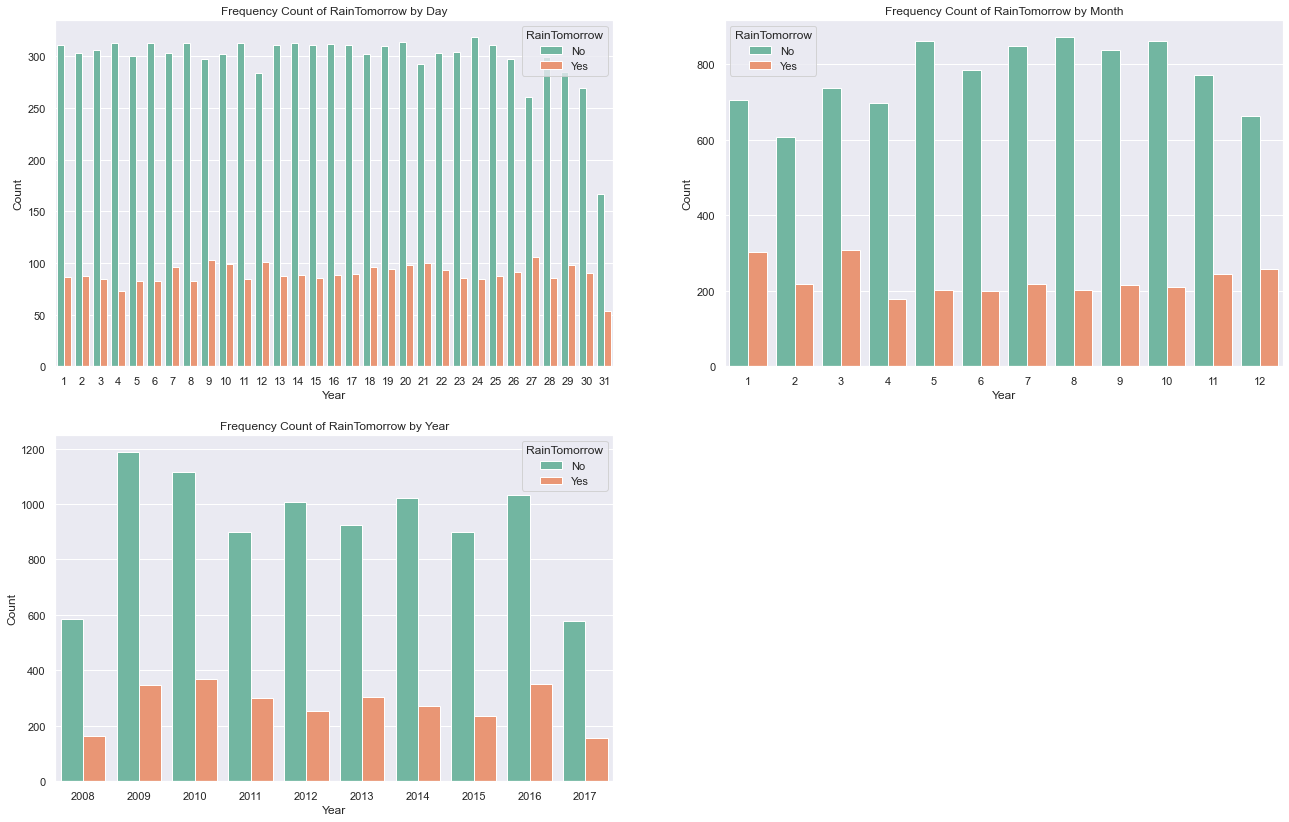

In [126]:
sns.set_style('darkgrid')
plt.figure(figsize=(22, 14))

plt.subplot(2,2,1)
sns.countplot(data=fishing_df_copy_no_missing_tranformed_full_ohc, x='Day', hue='RainTomorrow', palette='Set2')

plt.title('Frequency Count of RainTomorrow by Day')
plt.xlabel('Year')
plt.ylabel('Count')


plt.subplot(2,2,2)
sns.countplot(data=fishing_df_copy_no_missing_tranformed_full_ohc, x='Month', hue='RainTomorrow', palette='Set2')

plt.title('Frequency Count of RainTomorrow by Month')
plt.xlabel('Year')
plt.ylabel('Count')

plt.subplot(2,2,3)
sns.countplot(data=fishing_df_copy_no_missing_tranformed_full_ohc, x='Year', hue='RainTomorrow', palette='Set2')

plt.title('Frequency Count of RainTomorrow by Year')
plt.xlabel('Year')
plt.ylabel('Count')

plt.show()

From the barplot above, more fishermen there is not much observable trend in the year , month and day for RainTomorrow. Date seem to not be a factor in if it will RainTomorrow
One must take note that it is less likely to RainTomorrow as there is large amount of "No" value

To observe the extend of imbalance of class, we plot the following values below

77.0%
23.0%


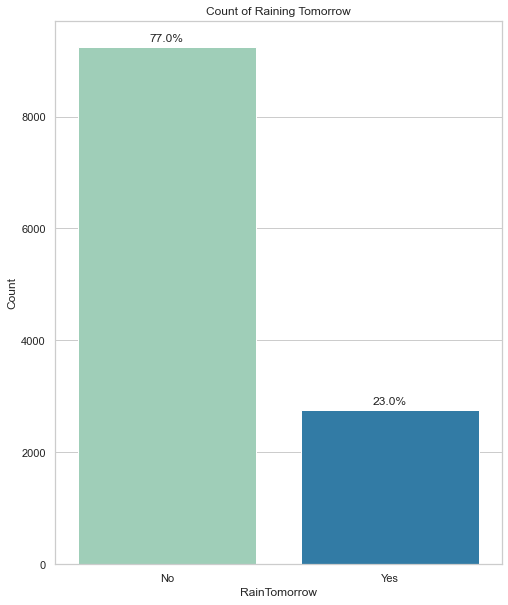

In [92]:
plt.figure(figsize=(8,10))
bar_plot = sns.countplot(x=fishing_df_copy_no_missing_tranformed_full_ohc['RainTomorrow'], palette='YlGnBu')
plt.title("Count of Raining Tomorrow")
plt.ylabel("Count")
for bar in bar_plot.patches:
    percentage = '{:.1f}%'.format(bar.get_height()/len(fishing_df_copy_no_missing_tranformed_full_ohc)*100)
    x_var = bar.get_x() + bar.get_width()/2
    y_var = bar.get_height() + 100
    bar_plot.annotate(percentage, (x_var, y_var), ha='center')

As you can see below, there is a imbalance of class for the reponse variable. As such I will use SMOTE(Synthetic Minority Over-sampling Technique) to treat the imbalance classess

In [133]:
fishing_df_copy_no_missing_tranformed_full_ohc_SMOTE = fishing_df_copy_no_missing_tranformed_full_ohc.drop(columns = ["Date", "Day", "Month", "Year"], inplace = False)

In [151]:
X = fishing_df_copy_no_missing_tranformed_full_ohc_SMOTE.drop('RainTomorrow', axis=1, inplace = False)
y = fishing_df_copy_no_missing_tranformed_full_ohc_SMOTE['RainTomorrow']

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)
print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

fishing_df_copy_no_missing_tranformed_full_ohc_SMOTE_balance = pd.concat([X_sm,y_sm.to_frame()],axis=1)
print(fishing_df_copy_no_missing_tranformed_full_ohc_SMOTE_balance.shape)

Shape of X before SMOTE: (12006, 78)
Shape of X after SMOTE: (18500, 78)

Balance of positive and negative classes (%):
(18500, 79)


In [152]:
fishing_df_copy_no_missing_tranformed_full_ohc_SMOTE_balance.tail()

,Rainfall,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,AverageTemp,WindGustSpeed,WindSpeed9am,Evaporation,WindSpeed3pm,Sunshine,Location_Changi,Location_Sentosa,Location_Tuas,Location_Woodlands,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_EW,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NS,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,Pressure9am_high,Pressure9am_low,Pressure9am_med,Pressure3pm_high,Pressure3pm_low,Pressure3pm_med,RainToday_No,RainToday_Unknown,RainToday_Yes,ColourOfBoats_blue,ColourOfBoats_grey,ColourOfBoats_red,ColourOfBoats_white,RainTomorrow
18495,1.395280,81.000000,58.872050,6.872050,7.000000,35.674410,3.786145,2.708050,1.795765,2.895883,2.323636,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,Yes
18496,0.003336,63.995830,62.004170,1.002085,1.002085,36.796664,4.024249,2.943300,2.433026,3.662549,2.617154,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,Yes
18497,0.741416,68.000000,81.258584,7.258584,8.000000,28.343027,3.963443,3.412044,1.898716,2.989881,0.832909,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Yes
18498,0.917067,80.275795,95.724205,6.275795,8.000000,34.837898,3.634468,2.710043,1.825048,2.338108,1.526497,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,Yes
18499,0.000000,57.724105,58.091965,1.816070,2.908035,35.762052,3.961606,1.818216,2.568339,2.934210,2.475762,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,Yes


For the column "RainFall" mentioned earlier, one should check its skewness again

In [154]:
skewness_kurtosis_dataframe(fishing_df_copy_no_missing_tranformed_full_ohc_SMOTE_balance, ["Rainfall"])

Rainfall


,Skewness,Kurtosis,Skewness Category,Kurtosis Category
Rainfall,5.441755,45.028477,Highly skewed,Heavier tails


Text(0.5, 0, 'Sunshine/Number of hours of bright sunshine in the day')

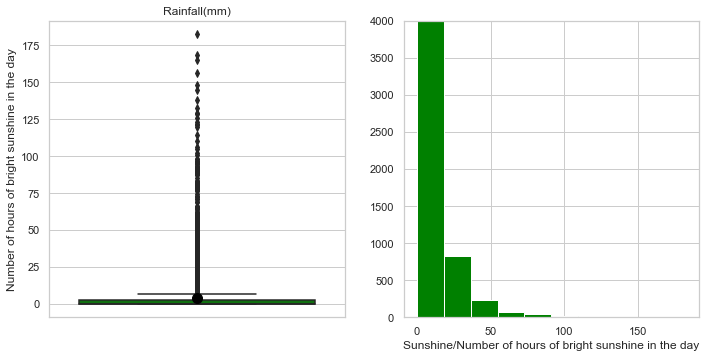

In [156]:
plt.figure(figsize=(18,12))
sns.set(style="whitegrid")
plt.subplot(2,3,1)
plt.title("Rainfall(mm)")
sns.boxplot(y="Rainfall",data=fishing_df_copy_no_missing_tranformed_full_ohc_SMOTE_balance,
            color = "green",
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel("Number of hours of bright sunshine in the day")

plt.subplot(2,3,2)
plt.ylim(0, 4000)
fishing_df_copy_no_missing_tranformed_full_ohc_SMOTE_balance["Rainfall"].hist(color ="green", bins = 10)
plt.xlabel("Sunshine/Number of hours of bright sunshine in the day")

As seen above, the data is still quite imbalance for the column of Rainfall
It seems that due to imbalance of data, it will be not feasible for transformation

In [175]:
final_df_no_target = fishing_df_copy_no_missing_tranformed_full_ohc_SMOTE_balance.drop(columns = ["RainTomorrow"], inplace = False)

In [182]:
pd.set_option('display.max_rows', 80)
skewness_kurtosis_dataframe(fishing_df_copy_no_missing_tranformed_full_ohc_SMOTE_balance, final_df_no_target.columns)

Rainfall
Humidity9am
Humidity3pm
Cloud9am
Cloud3pm
AverageTemp
WindGustSpeed
WindSpeed9am
Evaporation
WindSpeed3pm
Sunshine
Location_Changi
Location_Sentosa
Location_Tuas
Location_Woodlands
WindDir9am_E
WindDir9am_ENE
WindDir9am_ESE
WindDir9am_N
WindDir9am_NE
WindDir9am_NNE
WindDir9am_NNW
WindDir9am_NW
WindDir9am_S
WindDir9am_SE
WindDir9am_SSE
WindDir9am_SSW
WindDir9am_SW
WindDir9am_W
WindDir9am_WNW
WindDir9am_WSW
WindDir3pm_E
WindDir3pm_ENE
WindDir3pm_ESE
WindDir3pm_N
WindDir3pm_NE
WindDir3pm_NNE
WindDir3pm_NNW
WindDir3pm_NW
WindDir3pm_S
WindDir3pm_SE
WindDir3pm_SSE
WindDir3pm_SSW
WindDir3pm_SW
WindDir3pm_W
WindDir3pm_WNW
WindDir3pm_WSW
WindGustDir_E
WindGustDir_ENE
WindGustDir_ESE
WindGustDir_EW
WindGustDir_N
WindGustDir_NE
WindGustDir_NNE
WindGustDir_NNW
WindGustDir_NS
WindGustDir_NW
WindGustDir_S
WindGustDir_SE
WindGustDir_SSE
WindGustDir_SSW
WindGustDir_SW
WindGustDir_W
WindGustDir_WNW
WindGustDir_WSW
Pressure9am_high
Pressure9am_low
Pressure9am_med
Pressure3pm_high
Pressure3pm_lo

,Skewness,Kurtosis,Skewness Category,Kurtosis Category
Rainfall,5.441755,45.028477,Highly skewed,Heavier tails
Humidity9am,-0.397752,0.058380,Fairly symmetrical,Lighter tails
Humidity3pm,-0.031252,-0.233555,Fairly symmetrical,Lighter tails
Cloud9am,-0.462606,-1.325622,Fairly symmetrical,Lighter tails
Cloud3pm,-0.513662,-1.233754,Moderately skewed (left),Lighter tails
AverageTemp,-0.226332,-1.190065,Fairly symmetrical,Lighter tails
WindGustSpeed,-0.023022,0.159678,Fairly symmetrical,Lighter tails
WindSpeed9am,0.043645,-0.129146,Fairly symmetrical,Lighter tails
Evaporation,-0.340401,-0.338339,Fairly symmetrical,Lighter tails
WindSpeed3pm,-0.442699,0.349878,Fairly symmetrical,Lighter tails


From the skewness and Kurtosis,it seems that apart from "Sunshine" and "Rainfall" that I was not able to address the skewness the rest of the non-OHC columns are either moderately skewed or Fairly symmertical

Once must note that the Highly skewed part of the OHC is due the nature of OHC which leads to more sparsity

### Variance Influence Factors

In [184]:
vif_temp_df = final_df_no_target.astype(float)
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(vif_temp_df.values, i) for i in range(vif_temp_df.shape[1])]
vif_info['Column'] = vif_temp_df.columns
vif_info.sort_values('VIF', ascending = False)

,VIF,Column
6,328.002455,WindGustSpeed
5,307.685305,AverageTemp
9,122.297350,WindSpeed3pm
7,64.009533,WindSpeed9am
8,62.476977,Evaporation
1,54.107421,Humidity9am
10,43.888482,Sunshine
2,33.279509,Humidity3pm
4,12.187952,Cloud3pm
67,10.795256,Pressure9am_med


From the Variance Influence Factors(VIF), if VIF > 10, there exisits multi-collinearity
- If the model that we use depends on the linearity assumption, it will wise to remove those columns
 -However, tree-based models might be more robust and the columns could still be kept

## Correlation Matrix for Numerical Exploratory variables 
- KIV do Categorial Variables first

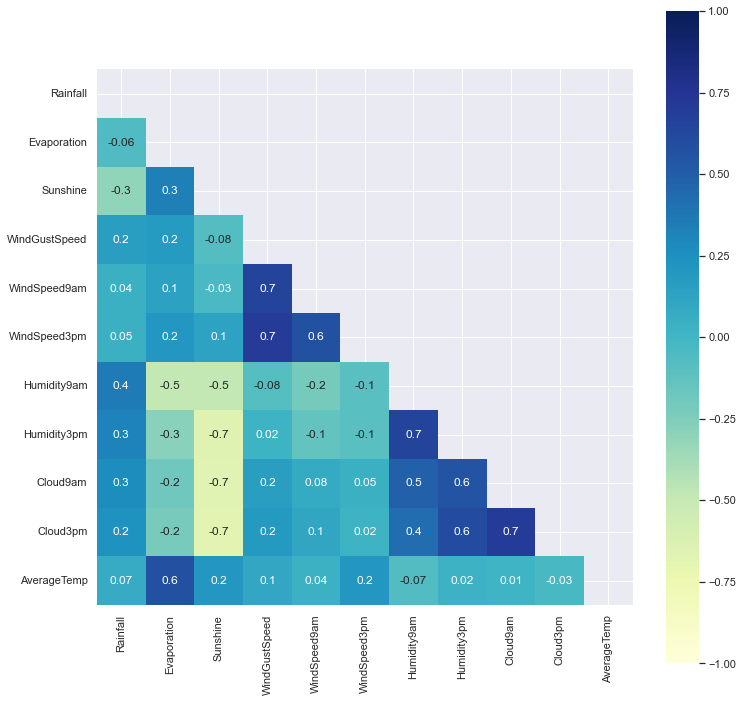

In [195]:
cat_corr = final_df_no_target[numerical_cols].corr()
half = np.triu(cat_corr)
sns.heatmap(cat_corr, xticklabels=cat_corr.columns.values, yticklabels=cat_corr.columns.values,
            annot=True, vmin=-1, vmax=1, fmt='.1g', cmap='YlGnBu', square=True, mask=half)
sns.set(rc = {'figure.figsize':(12,12)})

From the correlation matrix, it is observed that is a somewhat high correlation(0.7 and above)

- WindSpeed9am and WindGustSpeed
- WindSpeed3pm and WindGustSpeed
- Humidity3pm and Humidity9am
- Cloud3pm and Cloud9am

Again, if we use a linear model, it might be useful to remove WindGustSpeed, (Humidity3pm or Humidity 9am) , (Cloud3pm or Cloud9am)

#### In Summary, these are the preprocessing steps to be conducted for Machine Learning Pipeline